In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# 압축 해제하는 명령어
# !unzip /content/drive/MyDrive/busanit501-1234/train.zip -d /content/drive/MyDrive/busanit501-1234/class/


In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# 데이터 변환 (이미지 크기 조정, 정규화)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG 스타일 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(root='./training_set', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 목록 확인
class_names = train_dataset.classes
print(f"✅ 클래스 목록: {class_names}")


✅ 클래스 목록: ['cats', 'dogs']


In [2]:
# from google.colab import drive
import os


# 데이터 폴더 경로 설정
# data_dir = "/content/drive/MyDrive/busanit501-1234/class/"

# 폴더 안에 있는 클래스 확인
print("🔍 데이터셋 폴더 내 클래스 확인:")
print(os.listdir('./training_set'))


🔍 데이터셋 폴더 내 클래스 확인:
['dogs', 'cats']


In [3]:
import torch.nn as nn
import torch.optim as optim

# CNN 모델 정의 (은닉층 2개 포함)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # 이미지 크기 224x224 → 56x56 풀링 후
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 클래스 개수 설정
num_classes = len(class_names)
model = CustomCNN(num_classes)

# 최적화 함수 및 손실 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 10  # 학습 횟수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("🚀 모델 학습 시작...")
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # 1번마다 손실값 출력
        if (i + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
            running_loss = 0.0


🚀 모델 학습 시작...
Epoch [1/10], Step [1/251], Loss: 0.0067
Epoch [1/10], Step [2/251], Loss: 0.0062
Epoch [1/10], Step [3/251], Loss: 0.0065
Epoch [1/10], Step [4/251], Loss: 0.0075
Epoch [1/10], Step [5/251], Loss: 0.0070
Epoch [1/10], Step [6/251], Loss: 0.0066
Epoch [1/10], Step [7/251], Loss: 0.0071
Epoch [1/10], Step [8/251], Loss: 0.0067
Epoch [1/10], Step [9/251], Loss: 0.0071
Epoch [1/10], Step [10/251], Loss: 0.0064
Epoch [1/10], Step [11/251], Loss: 0.0066
Epoch [1/10], Step [12/251], Loss: 0.0068
Epoch [1/10], Step [13/251], Loss: 0.0066
Epoch [1/10], Step [14/251], Loss: 0.0069
Epoch [1/10], Step [15/251], Loss: 0.0066
Epoch [1/10], Step [16/251], Loss: 0.0074
Epoch [1/10], Step [17/251], Loss: 0.0068
Epoch [1/10], Step [18/251], Loss: 0.0067
Epoch [1/10], Step [19/251], Loss: 0.0067
Epoch [1/10], Step [20/251], Loss: 0.0058
Epoch [1/10], Step [21/251], Loss: 0.0061
Epoch [1/10], Step [22/251], Loss: 0.0066
Epoch [1/10], Step [23/251], Loss: 0.0066
Epoch [1/10], Step [24/251], 

In [6]:
model_path = "./custom_cnn2.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ 학습된 모델이 저장되었습니다: {model_path}")


✅ 학습된 모델이 저장되었습니다: ./custom_cnn2.pth


In [30]:
# 모델 불러오기
def load_model(model_path, num_classes):
    model = CustomCNN(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 저장된 모델 불러오기
loaded_model = load_model(model_path, num_classes)


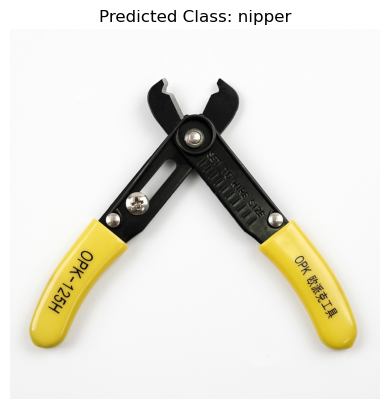

🔍 예측된 클래스: nipper


In [33]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_sample(image_path, model):
    """
    저장된 CNN 모델을 사용하여 샘플 이미지를 예측하는 함수.
    """
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)  # 배치 차원 추가 (1, 3, 224, 224)

    # 모델 예측
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # 결과 출력
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

    print(f"🔍 예측된 클래스: {class_names[predicted.item()]}")

# 🏆 샘플 이미지 예측 실행 (사용자 이미지 입력)
sample_image = "./sample.png"
predict_sample(sample_image, loaded_model)
